In [1]:
import pandas as pd
import numpy as np

In [2]:
data=pd.read_csv('Desktop/PROJECT/eda_data.csv',low_memory=False)

In [3]:
data=data.drop(['home_ownership_grouped','verification_status_clean'],axis=1)

In [4]:
cols_to_fill = ['mths_since_last_delinq','total_rev_hi_lim','tot_cur_bal','tot_coll_amt','revol_util','collections_12_mths_ex_med']  

for col in cols_to_fill:
    data[col] = data[col].fillna(data[col].median())


In [5]:
data['emp_title'] = data['emp_title'].fillna('Unknown')


In [6]:
data=data.dropna(axis=0)

In [7]:
for col in data.select_dtypes(include=['int32','int64']).columns:
    data[col] = data[col].astype('float64')


In [8]:
data.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
       'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'emp_title_missing_flag', 'emp_length_missing_flag',
       'title_missing_flag', 'mths_since_last_delinq_missing_flag',
       'revol_util_missing_flag', 'collections_12_mths_ex_med_missing_flag',
       'tot_coll_amt_missing_flag', 'tot_cur_bal_missing_flag',
       'total_rev_hi_lim_missing_flag'],
      dtype='object')

In [9]:

data['issue_d'] = pd.to_datetime(data['issue_d'], format='%b-%Y', errors='coerce')
data['issue_d'] = data['issue_d'].dt.year


In [10]:
data['issue_d'].value_counts()

2014    60418
2013    58495
2012    41727
2015    28811
2011    16527
2010    10037
2009     4121
2008     1315
2007      206
Name: issue_d, dtype: int64

In [11]:
drop_for_iv = ['member_id', 'url',
    'funded_amnt', 'funded_amnt_inv',
    'emp_title', 'title',
    'zip_code',
    'pymnt_plan', 'policy_code']

data= data.drop(columns=drop_for_iv, errors='ignore')


In [12]:
data.shape

(221657, 40)

In [13]:
missing_flag_cols = [col for col in data.columns if col.endswith('_missing_flag')]
missing_flags_df = data[missing_flag_cols]


In [14]:
data = data.drop(columns=missing_flag_cols)


In [15]:
default_rate_by_purpose = data.groupby('purpose')['loan_status'].mean()
sorted_purposes = default_rate_by_purpose.sort_values()
# Step 3: Define 6 risk labels: A (safest) to F (riskiest)
risk_labels = ['A', 'B', 'C', 'D', 'E', 'F','G']
chunks = np.array_split(sorted_purposes.index, len(risk_labels))
purpose_risk_mapping = {}
for label, group in zip(risk_labels, chunks):
    for purpose in group:
        purpose_risk_mapping[purpose] = label
data['purpose'] = data['purpose'].map(purpose_risk_mapping).fillna('D')
for purpose, group in purpose_risk_mapping.items():
    rate = default_rate_by_purpose[purpose]
    print(f"{purpose:<25} → Group {group}  (Default Rate: {rate:.4f})")


educational               → Group A  (Default Rate: 0.0000)
wedding                   → Group A  (Default Rate: 0.0047)
car                       → Group B  (Default Rate: 0.0259)
renewable_energy          → Group B  (Default Rate: 0.0405)
major_purchase            → Group C  (Default Rate: 0.0457)
house                     → Group C  (Default Rate: 0.0527)
credit_card               → Group D  (Default Rate: 0.0554)
vacation                  → Group D  (Default Rate: 0.0579)
medical                   → Group E  (Default Rate: 0.0585)
home_improvement          → Group E  (Default Rate: 0.0594)
other                     → Group F  (Default Rate: 0.0606)
moving                    → Group F  (Default Rate: 0.0659)
small_business            → Group G  (Default Rate: 0.0664)
debt_consolidation        → Group G  (Default Rate: 0.0688)


In [16]:
import pandas as pd
import numpy as np

def calculate_iv(df, target):
    iv_dict = {}
    for col in df.select_dtypes(include='object'):
        if df[col].isnull().any():
            df[col] = df[col].fillna('Missing')
        temp = df.groupby(col)[target].agg(['count', 'sum'])
        temp['non_event'] = temp['count'] - temp['sum']
        temp['event_rate'] = temp['sum'] / df[target].sum()
        temp['non_event_rate'] = temp['non_event'] / (df[target]==0).sum()
        temp['woe'] = np.log((temp['event_rate'] + 1e-6) / (temp['non_event_rate'] + 1e-6))
        temp['iv'] = (temp['event_rate'] - temp['non_event_rate']) * temp['woe']
        iv_dict[col] = temp['iv'].sum()
    return pd.DataFrame.from_dict(iv_dict, orient='index', columns=['IV']).sort_values(by='IV', ascending=False)

# Usage
iv_result = calculate_iv(data, 'loan_status')
print(iv_result)


                           IV
sub_grade            0.558700
grade                0.520064
initial_list_status  0.140790
earliest_cr_line     0.127871
verification_status  0.098914
purpose              0.045547
addr_state           0.036776
home_ownership       0.023430


In [17]:
import pandas as pd
from scipy.stats import chi2_contingency

def chi_square_significance(df, target, alpha=0.05):
    results = []
    cat_cols = df.select_dtypes(include='object').columns

    for col in cat_cols:
        # Fill missing with a label
        contingency = pd.crosstab(df[col].fillna('Missing'), df[target])
        if contingency.shape[0] > 1 and contingency.shape[1] > 1:
            chi2, p, dof, _ = chi2_contingency(contingency)
            results.append({
                'Feature': col,
                'Chi2': chi2,
                'p-value': p,
                'Significant': p < alpha
            })

    return pd.DataFrame(results).sort_values('p-value')

# Example usage
chi_results = chi_square_significance(data, 'loan_status')
print(chi_results)


               Feature         Chi2        p-value  Significant
0                grade  6664.119042   0.000000e+00         True
1            sub_grade  6997.569262   0.000000e+00         True
7  initial_list_status  2041.553452   0.000000e+00         True
3  verification_status  1144.319320  7.700245e-251         True
6     earliest_cr_line  2045.805952  1.671265e-147         True
5           addr_state   530.471503   1.679010e-81         True
4              purpose   348.198720   3.759775e-72         True
2       home_ownership   254.494279   6.978228e-55         True


In [18]:
data=data.drop(['addr_state','home_ownership','grade'],axis=1)

In [19]:
from scipy.stats import pointbiserialr
num_cols = data.select_dtypes(include=['int64', 'float64']).columns.difference(['loan_status'])
results = []
for col in num_cols:
    mask = data[col].notna() & data['loan_status'].notna()
    corr, p = pointbiserialr(data[col][mask], data['loan_status'][mask])
    results.append({
        'Feature': col,
        'Corr': corr,
        'p-value': p,
        'Significant': p < 0.05
    })
results_df = pd.DataFrame(results).sort_values('p-value')
print(results_df)


                       Feature      Corr        p-value  Significant
10                     issue_d  0.223324   0.000000e+00         True
17                        term  0.118100   0.000000e+00         True
4                          dti  0.111336   0.000000e+00         True
6                           id  0.268816   0.000000e+00         True
9                     int_rate  0.150488   0.000000e+00         True
11                   loan_amnt  0.067025  4.938191e-219         True
8                  installment  0.054080  3.320916e-143         True
3                  delinq_2yrs  0.053111  3.504849e-138         True
16                  revol_util  0.050563  2.048978e-125         True
14                     pub_rec  0.040974   5.498470e-83         True
13                    open_acc  0.040071   1.897856e-79         True
2   collections_12_mths_ex_med  0.032603   3.348147e-53         True
12      mths_since_last_delinq -0.024532   7.259819e-31         True
0               acc_now_delinq  0.

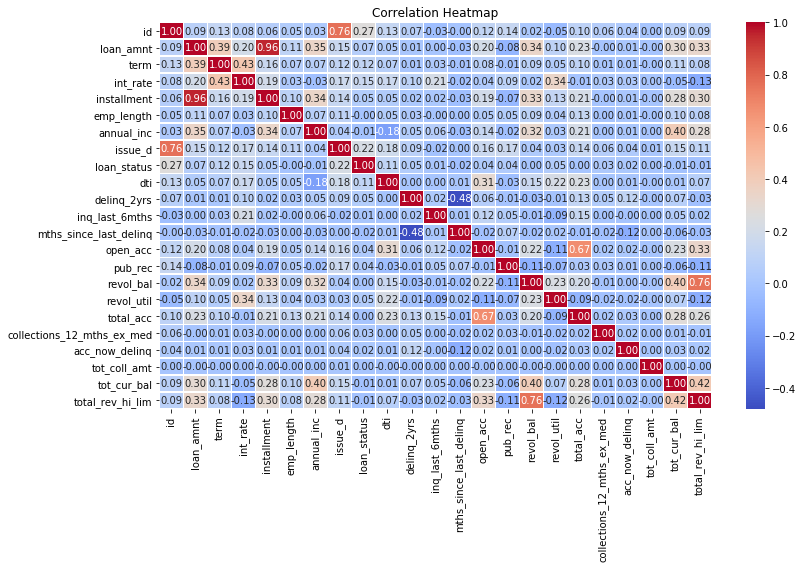

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
numeric_data = data.select_dtypes(include=['int64', 'float64'])
corr_matrix = numeric_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [21]:
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
independent_cols = numeric_cols.drop('loan_status', errors='ignore')
target_corr = data[independent_cols].corrwith(data['loan_status'])
target_corr_df = target_corr.to_frame(name='Correlation with loan_status').sort_values(by='Correlation with loan_status', 
                                                                                       ascending=False)
print(target_corr_df)


                            Correlation with loan_status
id                                              0.268816
issue_d                                         0.223324
int_rate                                        0.150488
term                                            0.118100
dti                                             0.111336
loan_amnt                                       0.067025
installment                                     0.054080
delinq_2yrs                                     0.053111
revol_util                                      0.050563
pub_rec                                         0.040974
open_acc                                        0.040071
collections_12_mths_ex_med                      0.032603
acc_now_delinq                                  0.022787
inq_last_6mths                                  0.005920
revol_bal                                       0.003067
tot_coll_amt                                    0.000772
total_acc                      

In [22]:
low_corr_cols = [
    'tot_coll_amt',
    'total_acc',
    'emp_length',
    'revol_bal',
    'tot_cur_bal',
    'total_rev_hi_lim',
]
data = data.drop(columns=low_corr_cols)
print("Dropped columns:", low_corr_cols)


Dropped columns: ['tot_coll_amt', 'total_acc', 'emp_length', 'revol_bal', 'tot_cur_bal', 'total_rev_hi_lim']


In [23]:
data.shape

(221657, 22)

In [24]:
import pandas as pd

# Assume your DataFrame is named `data`
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns

# Dictionary to store number of outliers per column
outlier_counts = {}

# Loop through each numerical column
for col in numerical_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    outlier_counts[col] = len(outliers)

# Convert to DataFrame to view nicely
outlier_df = pd.DataFrame.from_dict(outlier_counts, orient='index', columns=['Outlier Count'])
outlier_df = outlier_df.sort_values(by='Outlier Count', ascending=False)

print(outlier_df)


                            Outlier Count
mths_since_last_delinq              97910
term                                45583
delinq_2yrs                         36199
pub_rec                             27811
inq_last_6mths                      17959
loan_status                         13946
id                                  12463
annual_inc                           8934
loan_amnt                            7185
installment                          6284
open_acc                             3296
issue_d                              1521
collections_12_mths_ex_med           1469
int_rate                             1423
acc_now_delinq                        687
dti                                   370
revol_util                              9


In [25]:
import pandas as pd
import numpy as np

# 1. Drop irrelevant column
data.drop(columns=['id'], inplace=True, errors='ignore')

# 2. Bin 'mths_since_last_delinq' into 4 bins
if 'mths_since_last_delinq' in data.columns:
    data['mths_since_last_delinq_bin'] = pd.qcut(data['mths_since_last_delinq'], q=4, duplicates='drop')
    data.drop(columns=['mths_since_last_delinq'], inplace=True)

# 3. Create binary flags for columns that represent delinquencies
flag_cols = ['acc_now_delinq', 'collections_12_mths_ex_med']
for col in flag_cols:
    if col in data.columns:
        data[col + '_flag'] = np.where(data[col] > 0, 1, 0)
        data.drop(columns=[col], inplace=True)

# 4. Extract year from 'issue_d'
if 'issue_d' in data.columns:
    data['issue_d'] = pd.to_datetime(data['issue_d'], errors='coerce')
    data['issue_year'] = data['issue_d'].dt.year
    data.drop(columns=['issue_d'], inplace=True)

# 5. Cap outliers using IQR method
outlier_cols = [
    'delinq_2yrs', 'pub_rec', 'inq_last_6mths', 'open_acc',
    'annual_inc', 'loan_amnt', 'installment', 'int_rate',
    'dti', 'revol_util'
]

for col in outlier_cols:
    if col in data.columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        data[col] = np.where(data[col] > upper, upper,
                             np.where(data[col] < lower, lower, data[col]))

# Done
print("Cleaned data shape:", data.shape)
print(data.head())


Cleaned data shape: (221657, 21)
   loan_amnt  term  int_rate  installment sub_grade  annual_inc  \
0     5000.0   3.0     10.65       162.87        B2     24000.0   
1     2400.0   3.0     15.96        84.33        C5     12252.0   
2    10000.0   3.0     13.49       339.31        C1     49200.0   
3     5000.0   3.0      7.90       156.46        A4     36000.0   
4     3000.0   3.0     18.64       109.43        E1     48000.0   

  verification_status  loan_status purpose    dti  ...  earliest_cr_line  \
0            Verified          0.0       D  27.65  ...          Jan-1985   
1        Not Verified          0.0       G   8.72  ...          Nov-2001   
2            Verified          0.0       F  20.00  ...          Feb-1996   
3            Verified          0.0       A  11.20  ...          Nov-2004   
4            Verified          0.0       B   5.35  ...          Jan-2007   

  inq_last_6mths  open_acc  pub_rec  revol_util  initial_list_status  \
0            1.0       3.0      0.0

In [26]:
data.shape

(221657, 21)

In [27]:
import pandas as pd

# Assume your DataFrame is named `data`
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns

# Dictionary to store number of outliers per column
outlier_counts = {}

# Loop through each numerical column
for col in numerical_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    outlier_counts[col] = len(outliers)

# Convert to DataFrame to view nicely
outlier_df = pd.DataFrame.from_dict(outlier_counts, orient='index', columns=['Outlier Count'])
outlier_df = outlier_df.sort_values(by='Outlier Count', ascending=False)

print(outlier_df)


                Outlier Count
term                    45583
loan_status             13946
loan_amnt                   0
int_rate                    0
installment                 0
annual_inc                  0
dti                         0
delinq_2yrs                 0
inq_last_6mths              0
open_acc                    0
pub_rec                     0
revol_util                  0
issue_year                  0


In [28]:

# Identify all categorical columns
cat_cols = data.select_dtypes(include=['object', 'category']).columns

# Encode each categorical column
for col in cat_cols:
    unique_vals = data[col].nunique()

    if unique_vals == 2:
        # Binary encoding
        data[col] = data[col].astype('category').cat.codes
    elif unique_vals > 2:
        # One-hot encoding
        dummies = pd.get_dummies(data[col], prefix=col, drop_first=True)
        data = pd.concat([data.drop(col, axis=1), dummies], axis=1)

# 'data' is now numeric and ready for model fitting